# Cox-PH and DeepSurv

In this notebook we will train the [Cox-PH method](http://jmlr.org/papers/volume20/18-424/18-424.pdf), also known as [DeepSurv](https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/s12874-018-0482-1).
We will use the METABRIC data sets as an example

A more detailed introduction to the `pycox` package can be found in [this notebook](https://nbviewer.jupyter.org/github/havakv/pycox/blob/master/examples/01_introduction.ipynb) about the `LogisticHazard` method.

The main benefit Cox-CC (and the other Cox methods) has over Logistic-Hazard is that it is a continuous-time method, meaning we do not need to discretize the time scale.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

from pycox.datasets import metabric
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

In [10]:
## Uncomment to install `sklearn-pandas`
# ! pip install sklearn-pandas

In [2]:
np.random.seed(1234)
_ = torch.manual_seed(123)

## Dataset

We load the METABRIC data set and split in train, test and validation.

In [3]:
df_train = metabric.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [4]:
df_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
0,5.603834,7.811392,10.797988,5.967607,1.0,1.0,0.0,1.0,56.840000,99.333336,0
1,5.284882,9.581043,10.204620,5.664970,1.0,0.0,0.0,1.0,85.940002,95.733330,1
3,6.654017,5.341846,8.646379,5.655888,0.0,0.0,0.0,0.0,66.910004,239.300003,0
4,5.456747,5.339741,10.555724,6.008429,1.0,0.0,0.0,1.0,67.849998,56.933334,1
5,5.425826,6.331182,10.455145,5.749053,1.0,1.0,0.0,1.0,70.519997,123.533333,0


## Feature transforms
We have 9 covariates, in addition to the durations and event indicators.

We will standardize the 5 numerical covariates, and leave the binary variables as is. As variables needs to be of type `'float32'`, as this is required by pytorch.

In [5]:
cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [6]:
standardize

[(['x0'], StandardScaler()),
 (['x1'], StandardScaler()),
 (['x2'], StandardScaler()),
 (['x3'], StandardScaler()),
 (['x8'], StandardScaler())]

In [7]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

We need no label transforms

In [8]:
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = x_val, y_val

In [43]:
val

(array([[-0.38457575, -0.89326   , -0.74212027, ...,  0.        ,
          0.        ,  1.        ],
        [-0.3665086 , -0.3167301 ,  0.05380753, ...,  1.        ,
          0.        ,  1.        ],
        [-0.5659799 , -0.83177716, -0.9836813 , ...,  1.        ,
          1.        ,  1.        ],
        ...,
        [-0.5302728 ,  0.5557188 ,  0.24615282, ...,  0.        ,
          0.        ,  1.        ],
        [-0.8310751 ,  0.80899894,  0.56936073, ...,  0.        ,
          0.        ,  1.        ],
        [-0.7328408 ,  0.42610374, -0.10061071, ...,  0.        ,
          0.        ,  1.        ]], dtype=float32),
 (array([ 85.73333  ,  55.666668 , 143.6      , 117.       , 183.2      ,
         151.9      ,  37.8      , 128.36667  , 141.56667  ,   2.5333333,
         225.5      ,  21.9      , 174.56667  , 130.46666  , 113.566666 ,
          34.3      , 163.1      , 111.53333  , 128.2      ,  17.833334 ,
          55.733334 , 226.7      , 239.16667  , 168.26666  , 1

## Neural net

We create a simple MLP with two hidden layers, ReLU activations, batch norm and dropout. 
Here, we just use the `torchtuples.practical.MLPVanilla` net to do this.

Note that we set `out_features` to 1, and that we have not `output_bias`.

In [10]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

## Training the model

To train the model we need to define an optimizer. You can choose any `torch.optim` optimizer, but here we instead use one from `tt.optim` as it has some added functionality.
We use the `Adam` optimizer, but instead of choosing a learning rate, we will use the scheme proposed by [Smith 2017](https://arxiv.org/pdf/1506.01186.pdf) to find a suitable learning rate with `model.lr_finder`. See [this post](https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6) for an explanation.

In [13]:
model = CoxPH(net, tt.optim.Adam)

In [14]:
?CoxPH

Init signature: CoxPH(net, optimizer=None, device=None, loss=None)
Docstring:     
Cox proportional hazards model parameterized with a neural net.
This is essentially the DeepSurv method [1].

The loss function is not quite the partial log-likelihood, but close.    
The difference is that for tied events, we use a random order instead of 
including all individuals that had an event at that point in time.

Arguments:
    net {torch.nn.Module} -- A pytorch net.

Keyword Arguments:
    optimizer {torch or torchtuples optimizer} -- Optimizer (default: {None})
    device {str, int, torch.device} -- Device to compute on. (default: {None})
        Preferably pass a torch.device object.
        If 'None': use default gpu if available, else use cpu.
        If 'int': used that gpu: torch.device('cuda:<device>').
        If 'string': string is passed to torch.device('string').

[1] Jared L. Katzman, Uri Shaham, Alexander Cloninger, Jonathan Bates, Tingting Jiang, and Yuval Kluger.
    Deepsurv: 

d:\software\Anaconda\envs\DL\lib\site-packages\torchtuples\base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs))


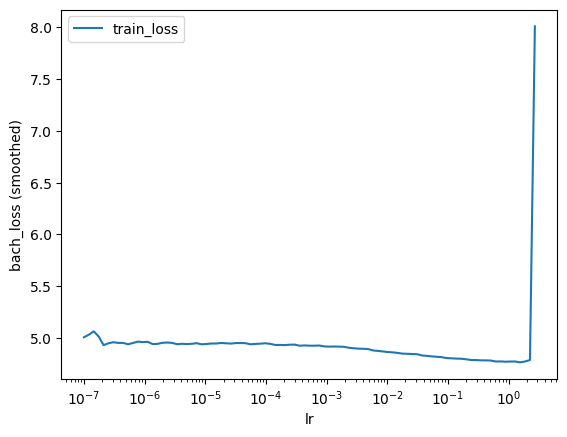

In [15]:
batch_size = 256
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()

In [16]:
lrfinder.get_best_lr()

0.15556761439304817

Often, this learning rate is a little high, so we instead set it manually to 0.01

In [17]:
model.optimizer.set_lr(0.01)

In [18]:
print(f"模型运行于: {'GPU' if next(model.net.parameters()).is_cuda else 'CPU'}")

模型运行于: GPU


We include the `EarlyStopping` callback to stop training when the validation loss stops improving. After training, this callback will also load the best performing model in terms of validation loss.

In [19]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [49]:
callbacks = [
    tt.callbacks.EarlyStopping(patience=5, min_delta=0.0001),
    tt.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
]

AttributeError: module 'torchtuples.callbacks' has no attribute 'ReduceLROnPlateau'

In [20]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 4.7785,	val_loss: 3.9347
1:	[0s / 0s],		train_loss: 4.6944,	val_loss: 3.9215
2:	[0s / 0s],		train_loss: 4.6468,	val_loss: 3.9314
3:	[0s / 0s],		train_loss: 4.6229,	val_loss: 3.9204
4:	[0s / 0s],		train_loss: 4.6073,	val_loss: 3.9192
5:	[0s / 0s],		train_loss: 4.5768,	val_loss: 3.9312
6:	[0s / 0s],		train_loss: 4.5848,	val_loss: 3.9298
7:	[0s / 0s],		train_loss: 4.5782,	val_loss: 3.9339
8:	[0s / 0s],		train_loss: 4.5835,	val_loss: 3.9252
9:	[0s / 0s],		train_loss: 4.5626,	val_loss: 3.9312
10:	[0s / 0s],		train_loss: 4.5650,	val_loss: 3.9324
11:	[0s / 0s],		train_loss: 4.5568,	val_loss: 3.9348
12:	[0s / 0s],		train_loss: 4.5583,	val_loss: 3.9583
13:	[0s / 0s],		train_loss: 4.5360,	val_loss: 3.9636
14:	[0s / 0s],		train_loss: 4.5505,	val_loss: 3.9447
CPU times: total: 406 ms
Wall time: 405 ms


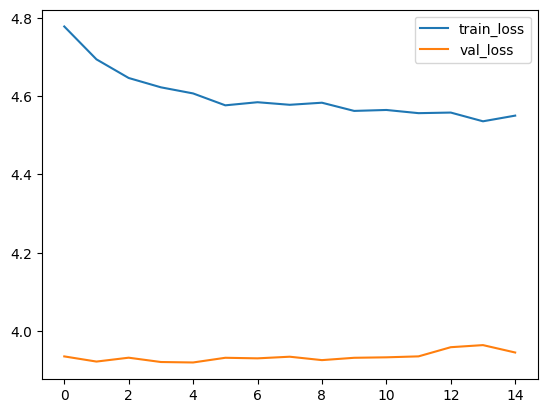

In [21]:
_ = log.plot()

We can get the partial log-likelihood

In [22]:
model.partial_log_likelihood(*val).mean()

-4.9678893

## Prediction

For evaluation we first need to obtain survival estimates for the test set.
This can be done with `model.predict_surv` which returns an array of survival estimates, or with `model.predict_surv_df` which returns the survival estimates as a dataframe.

However, as `CoxPH` is semi-parametric, we first need to get the non-parametric baseline hazard estimates with `compute_baseline_hazards`. 

Note that for large datasets the `sample` argument can be used to estimate the baseline hazard on a subset.

In [23]:
_ = model.compute_baseline_hazards()

In [24]:
surv = model.predict_surv_df(x_test)

In [25]:
surv

,0,1,2,3,4,5,6,7,8,9,...,371,372,373,374,375,376,377,378,379,380
duration,,,,,,,,,,,,,,,,,,,,,
0.100000,0.998681,0.999316,0.999398,0.999416,0.998596,0.999565,0.999543,0.999695,0.998564,0.998476,...,0.999387,0.998357,0.999043,0.999665,0.999234,0.999200,0.998710,0.998552,0.999401,0.998275
0.766667,0.998681,0.999316,0.999398,0.999416,0.998596,0.999565,0.999543,0.999695,0.998564,0.998476,...,0.999387,0.998357,0.999043,0.999665,0.999234,0.999200,0.998710,0.998552,0.999401,0.998275
1.233333,0.998681,0.999316,0.999398,0.999416,0.998596,0.999565,0.999543,0.999695,0.998564,0.998476,...,0.999387,0.998357,0.999043,0.999665,0.999234,0.999200,0.998710,0.998552,0.999401,0.998275
1.266667,0.998681,0.999316,0.999398,0.999416,0.998596,0.999565,0.999543,0.999695,0.998564,0.998476,...,0.999387,0.998357,0.999043,0.999665,0.999234,0.999200,0.998710,0.998552,0.999401,0.998275
1.433333,0.998681,0.999316,0.999398,0.999416,0.998596,0.999565,0.999543,0.999695,0.998564,0.998476,...,0.999387,0.998357,0.999043,0.999665,0.999234,0.999200,0.998710,0.998552,0.999401,0.998275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335.600006,0.004389,0.059986,0.083925,0.090435,0.003088,0.167367,0.152534,0.284679,0.002712,0.001884,...,0.080391,0.001157,0.019483,0.252473,0.042693,0.037235,0.004949,0.002578,0.084970,0.000826
335.733337,0.002317,0.043075,0.062695,0.068155,0.001564,0.135610,0.122250,0.245546,0.001353,0.000900,...,0.059751,0.000522,0.012256,0.214711,0.029454,0.025278,0.002650,0.001278,0.063568,0.000358
337.033325,0.002317,0.043075,0.062695,0.068155,0.001564,0.135610,0.122250,0.245546,0.001353,0.000900,...,0.059751,0.000522,0.012256,0.214711,0.029454,0.025278,0.002650,0.001278,0.063568,0.000358


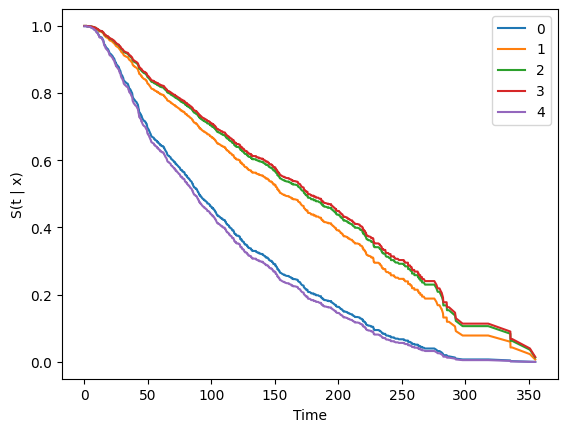

In [19]:
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

## Evaluation

We can use the `EvalSurv` class for evaluation the concordance, brier score and binomial log-likelihood. Setting `censor_surv='km'` means that we estimate the censoring distribution by Kaplan-Meier on the test set.

In [26]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [27]:
ev.concordance_td()

0.6562976775724699

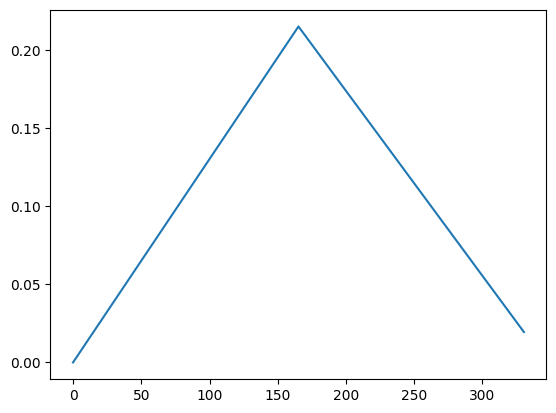

In [47]:
time_grid = np.linspace(durations_test.min(), durations_test.max(),3)
_ = ev.brier_score(time_grid).plot()

In [48]:
time_grid

array([  0.        , 165.18333435, 330.3666687 ])

In [45]:
ev.integrated_brier_score(time_grid)

0.009746873386078799

In [32]:
ev.integrated_nbll(time_grid)

0.4932198071182354